# BA Model Code

### Imports

In [1]:
import networkx
from datetime import datetime
import csv
from typing import Any
from itertools import combinations
import pandas
import networkx as nx
import random as random
import collections
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats


### Helper Functions

In [2]:
# Function to remove edges until reaching the target cluster count
def reach_target_clusters(old_graph, target_clusters):
    graph = old_graph.copy()
    
    current_clusters = nx.number_connected_components(graph)
    
    while current_clusters < target_clusters:
        # Filter edges where neither node has a degree of 1
        eligible_edges = [(u, v) for u, v in graph.edges if graph.degree[u] > 1 and graph.degree[v] > 1]
        
        # Check if there are eligible edges left to remove
        if not eligible_edges:
            print("No more eligible edges to remove.")
            break
        
        # Randomly select an eligible edge to remove
        edge_to_remove = random.choice(eligible_edges)
        graph.remove_edge(*edge_to_remove)
        
        # Recalculate the number of clusters
        current_clusters = nx.number_connected_components(graph)
                
    return graph

# Function to keep adding edges, but without tampering with the amount of clusters
def add_edges_keeping_clusters(old_graph, target_edges):
    graph = old_graph.copy()
    
    current_edge_count = graph.number_of_edges()
    current_clusters = nx.number_connected_components(graph)
    
    # Get a list of clusters (connected components)
    clusters = list(nx.connected_components(graph))

    while current_edge_count < target_edges:
        # Pick a random cluster
        cluster = random.choice(clusters)
        
        # Select two random nodes from this cluster
        if len(cluster) > 2:  # Ensure cluster has at least 3 nodes to form a new edge
            node1, node2 = random.sample(list(cluster), 2)
            
            # If there's no edge between them, try to add one
            if not graph.has_edge(node1, node2):
                graph.add_edge(node1, node2)
                
                # Check if the cluster count remains the same
                new_clusters = nx.number_connected_components(graph)
                if new_clusters == current_clusters:
                    # If no new cluster was formed, keep the edge
                    current_edge_count += 1
                else:
                    # If a new cluster is formed, remove the edge
                    graph.remove_edge(node1, node2)
                    
    return graph

# Helper functions for computing the stats of a graph
def connectedComponents(G: nx.Graph):
    return len([c for c in nx.connected_components(G)])

def avgClusteringCoeff(G: nx.Graph):
    try:
        clst = nx.clustering(G)

        sum = np.sum([i for i in clst.values()])
        cnt = len(clst)
    except:
        return -1

    return sum / cnt

def modularity(G: nx.Graph):
    return nx.community.modularity(
        G, [x for x in nx.community.greedy_modularity_communities(G)]
    )


def printStats(G: nx.Graph):
    ds = [d for _, d in G.degree()]  # type:ignore
    paths = [j.values() for (i, j) in nx.shortest_path_length(G)]
    avgLength = np.mean([max(j) for j in paths])
    maxLength = np.max([max(j) for j in paths])
    print(f"Nodes: {len(G.nodes)}")
    print(f"Edges: {len(G.edges)}")
    print(f"Degree: (Min: {np.min(ds)}, Max: {np.max(ds)}, Avg: {np.mean(ds)})")
    print(f"Connected components: {connectedComponents(G)}")
    print(f"Avg path length: {avgLength}")
    print(f"Diameter: {maxLength}")
    print(f"Radius: {maxLength / 2}")
    print(f"Average clustering coeff: {avgClusteringCoeff(G)}")
    print(f"Modularity: {modularity(G)}")

This section defines several utility functions to manipulate and analyze graphs, essential for the network analysis of the White Helmets dataset. The reach_target_clusters function iteratively removes edges from a graph to increase the number of connected components (clusters) until reaching a target number, ensuring that the network is broken into desired clusters for specific analytical purposes. Meanwhile, add_edges_keeping_clusters adds edges within clusters without increasing the total number of clusters, effectively increasing connectivity without altering the core structure. This function is particularly valuable for network generation models where cluster structure needs to remain consistent.

In addition to structural modification, helper functions connectedComponents, avgClusteringCoeff, and modularity compute key graph metrics: the number of connected components, average clustering coefficient, and modularity, respectively. These metrics help compare the generated network to real-world data. Finally, printStats provides a summary of network characteristics, including node and edge count, degree statistics, path lengths, clustering coefficient, and modularity. These metrics allow for a quantitative comparison between different network models and the White Helmets dataset.

### Create User-User Graph 

In [3]:
df = pandas.read_csv('data/pairwise_52seconds_share.csv')

filtered_df = df[df['userID_1'] != df['userID_2']]

network = filtered_df[['userID_1', 'userID_2']]

G = nx.from_pandas_edgelist(network, 'userID_1', 'userID_2')
nx.write_gexf(G, "networks/all_users.gexf")

printStats(G)

Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.29979262672811063
Modularity: 0.9955115981374059


In this section, the code reads the White Helmets dataset and processes it to build a network graph. After loading the dataset, it filters out self-links to focus on unique interactions between different users, which is crucial for accurately modeling the network's social structure. The edges between users are extracted and transformed into a graph using NetworkX, representing the connections between users as nodes and their interactions as edges. This step is fundamental as it converts raw data into a graph format, setting the stage for analyzing the structure and comparing it against baseline network models. The printStats function then provides an initial statistical summary, offering insights into the actual network's structure as a baseline for further comparison.

### BA Graph

In [4]:
# Original graph parameters
n_nodes_og = 4030
average_degree_og = 2.023821339950372

# Calculate m for the BA model (closest integer to half of the average degree)
m = 1#math.ceil(average_degree_og / 2)

# Generate a Barabási–Albert graph
print("Creating graph...")
G_ba_1 = nx.barabasi_albert_graph(n_nodes_og, m)

print("Creating more clusters...")
G_ba_2 = reach_target_clusters(G_ba_1, 1155)

print("Adding more edges...")
G_ba_3 = add_edges_keeping_clusters(G_ba_2, 4078)

printStats(G_ba_3)

Creating graph...
Creating more clusters...
Adding more edges...
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 62, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 1.5034739454094292
Diameter: 4
Radius: 2.0
Average clustering coeff: 0.4807145099250428
Modularity: 0.997135913444541


This section generates a single instance of a Barabási–Albert (BA) graph, a well-known model for creating networks with a scale-free degree distribution. The parameters for the model, such as the number of nodes and average degree, are derived from the White Helmets dataset, ensuring the generated model aligns as closely as possible with the actual data in terms of basic connectivity.

After generating the BA graph, the code calls reach_target_clusters to create additional clusters in the graph to match the clustering characteristics of the White Helmets network. Subsequently, it uses add_edges_keeping_clusters to add more edges without altering the cluster count, thus closely mimicking the edge density of the real network. The section ends with a statistical printout of the modified BA model, offering a comparison between the generated and real networks on essential structural features.

Iteration 1 of 100
Chi-squared Statistic: 48642.667770592016
New best model found...! Computing statistics...
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 98, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 1.5260545905707197
Diameter: 5
Radius: 2.5
Average clustering coeff: 0.4637903759289503
Modularity: 0.9970239476841747
----------------------------------------------------------------------------------------------------
Iteration 2 of 100
Chi-squared Statistic: 56647.14461011065
----------------------------------------------------------------------------------------------------
Iteration 3 of 100
Chi-squared Statistic: 52952.77843408602
----------------------------------------------------------------------------------------------------
Iteration 4 of 100
Chi-squared Statistic: 47411.2140720834
New best model found...! Computing statistics...
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 44, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 1.45

Chi-squared Statistic: 72656.12022513662
----------------------------------------------------------------------------------------------------
Iteration 46 of 100
Chi-squared Statistic: 67114.55446575445
----------------------------------------------------------------------------------------------------
Iteration 47 of 100
Chi-squared Statistic: 44332.566752777784
----------------------------------------------------------------------------------------------------
Iteration 48 of 100
Chi-squared Statistic: 57262.882981681374
----------------------------------------------------------------------------------------------------
Iteration 49 of 100
Chi-squared Statistic: 46795.474348830176
----------------------------------------------------------------------------------------------------
Iteration 50 of 100
Chi-squared Statistic: 72040.38580932589
----------------------------------------------------------------------------------------------------
Iteration 51 of 100
Chi-squared Statistic: 46

Chi-squared Statistic: 83739.25503753823
----------------------------------------------------------------------------------------------------
Iteration 91 of 100
Chi-squared Statistic: 74503.31421176091
----------------------------------------------------------------------------------------------------
Iteration 92 of 100
Chi-squared Statistic: 88665.06894432801
----------------------------------------------------------------------------------------------------
Iteration 93 of 100
Chi-squared Statistic: 64035.90134308841
----------------------------------------------------------------------------------------------------
Iteration 94 of 100
Chi-squared Statistic: 36328.07979177359
----------------------------------------------------------------------------------------------------
Iteration 95 of 100
Chi-squared Statistic: 46795.47894464366
----------------------------------------------------------------------------------------------------
Iteration 96 of 100
Chi-squared Statistic: 31402

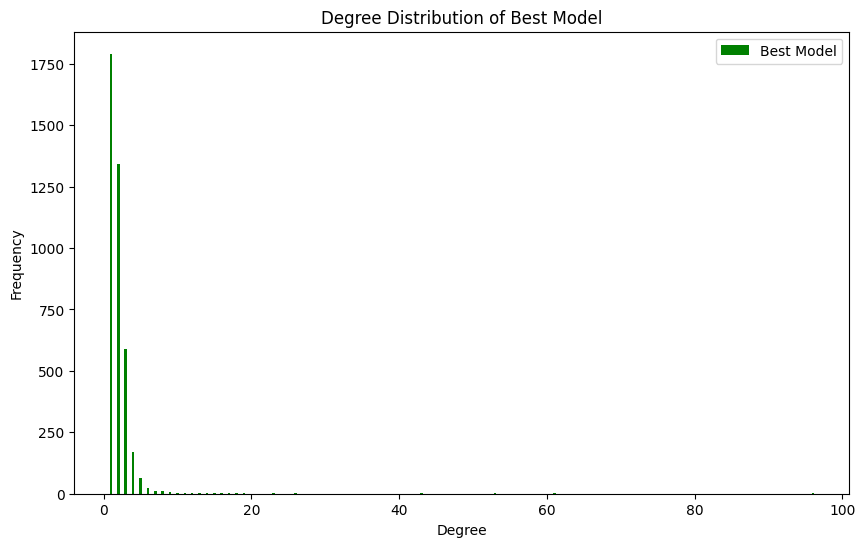

In [5]:
# Original graph parameters
n_nodes_og = 4030
average_degree_og = 2.023821339950372
m = 1#math.ceil(average_degree_og / 2)

# Placeholder for the best model and chi-squared value
best_chi2 = float('inf')
best_model = None

# Number of iterations
num_iterations = 100 

# Start the loop for X iterations
for iteration in range(num_iterations):
    print(f"Iteration {iteration+1} of {num_iterations}")

    # Generate initial Barabási–Albert graph
    G_ba_1 = nx.barabasi_albert_graph(n_nodes_og, m)

    # Modify graph to reach more clusters
    G_ba_2 = reach_target_clusters(G_ba_1, 1155)

    # Add edges while maintaining the number of clusters
    G_ba_3 = add_edges_keeping_clusters(G_ba_2, 4078)

    # Calculate degree sequences and frequencies for both graphs
    degree_sequence_ba = [d for _, d in G_ba_3.degree()]
    degree_count_ba = collections.Counter(degree_sequence_ba)
    deg_ba, cnt_ba = zip(*degree_count_ba.items())

    degree_sequence_g = [d for _, d in G.degree()]
    degree_count_g = collections.Counter(degree_sequence_g)
    deg_g, cnt_g = zip(*degree_count_g.items())

    probabilities_ba = [freq / sum(cnt_ba) for freq in cnt_ba]
    probabilities_g = [freq / sum(cnt_g) for freq in cnt_g]

    # Create a unified list of all degrees
    all_degrees = set(deg_ba).union(set(deg_g))

    # Adjust probabilities to ensure both lists cover all degrees
    probabilities_ba_extended = []
    probabilities_g_extended = []

    for degree in all_degrees:
        if degree in deg_ba:
            probabilities_ba_extended.append(probabilities_ba[deg_ba.index(degree)])
        else:
            probabilities_ba_extended.append(0)

        if degree in deg_g:
            probabilities_g_extended.append(probabilities_g[deg_g.index(degree)])
        else:
            probabilities_g_extended.append(0)

    epsilon = 1e-10  # Small constant to avoid division by zero

    # Apply smoothing to both probability distributions
    smoothed_probabilities_ba = [prob + epsilon for prob in probabilities_ba_extended]
    smoothed_probabilities_g = [prob + epsilon for prob in probabilities_g_extended]

    # Perform Chi-squared test
    chi2_stat, p_val = stats.chisquare(smoothed_probabilities_ba, smoothed_probabilities_g)

    print(f"Chi-squared Statistic: {chi2_stat}")

    # If this model has the best chi-squared value, save it
    if chi2_stat < best_chi2:
        best_chi2 = chi2_stat
        best_model = G_ba_3
        
        print(f"New best model found...! Computing statistics...")
        printStats(best_model)
        
    print("-"*100)

# After the loop, plot the best model
if best_model:
    degree_sequence_best = [d for _, d in best_model.degree()]
    degree_count_best = collections.Counter(degree_sequence_best)
    deg_best, cnt_best = zip(*degree_count_best.items())

    plt.figure(figsize=(10, 6))
    plt.bar(deg_best, cnt_best, width=0.35, color='g', label="Best Model", align='center')
    plt.title("Degree Distribution of Best Model")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [7]:
nx.write_gexf(best_model, f"networks/ba_model_best_{num_iterations}it.gexf")
printStats(best_model)

Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 96, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 1.4593052109181142
Diameter: 3
Radius: 1.5
Average clustering coeff: 0.4739506354947602
Modularity: 0.9968868467531146


In this section, the code iterates to generate multiple BA model graphs, refining the model to best fit the characteristics of the White Helmets dataset. It repeatedly creates a BA graph, modifies it to match the target cluster count and edge density, and then evaluates the resulting structure using the Chi-squared test on the degree distribution. This process enables empirical selection of the most representative model by minimizing the Chi-squared statistic, which measures how closely the degree distribution of the generated graph matches that of the real dataset.

For each generated model, the code calculates degree distributions and adjusts them to cover all possible degrees before computing Chi-squared statistics, helping to capture distribution similarities. If the Chi-squared statistic improves, the model is saved as the best candidate. The section concludes with a visualization of the degree distribution for the best model, providing a clear, empirical comparison to assess how well the chosen model replicates the structure of the White Helmets network. This rigorous approach provides a solid empirical basis for assessing the similarity between the generated and real-world networks.

### Conclusion and Discussion

The analysis aimed to evaluate how closely the network generated from the White Helmets dataset aligns with a baseline model created using the Barabási–Albert (BA) network generation process. To assess this alignment, we measured five core metrics: average path length, diameter, clustering coefficient, modularity, and degree distribution. By comparing these metrics between the original White Helmets network (OG model) and the best-performing generated model, we gain insights into the structural similarities and divergences between real-world social networks and theoretically generated scale-free networks.

Comparison of Network Metrics
Node and Edge Counts: Both networks maintain identical node and edge counts (4030 nodes, 4078 edges), allowing for a direct comparison on a structural level without the influence of different network sizes. This consistency ensures that variations in network characteristics are due to structural differences rather than size disparities.

Degree Distribution: While both networks achieve the same average degree (approximately 2.02), the final model's degree range is significantly broader, with a maximum degree of 96 compared to the OG model’s maximum of 9. This discrepancy highlights the tendency of the BA model to produce highly connected “hub” nodes, a property characteristic of scale-free networks but less evident in the White Helmets network. The relatively even degree distribution of the White Helmets network suggests it may not follow the power-law distribution typical of a BA network, indicating a fundamental structural difference in connectivity patterns.

Average Path Length and Diameter: The OG model’s average path length of 3.34 and diameter of 27 reflect a longer, less direct network structure, typical in networks where connections are more uniformly distributed. In contrast, the final model's path length and diameter are significantly lower (1.46 and 3, respectively), due to the presence of highly connected hubs, which reduce the average distance between nodes. This suggests that while the White Helmets network requires multiple connections to link distant nodes, the generated network can achieve connectivity more quickly, again indicative of the underlying differences in network topology.

Clustering Coefficient: The final model’s clustering coefficient (0.47) is higher than the OG model’s coefficient (0.30), suggesting that nodes in the generated model are part of more tightly knit groups than in the actual White Helmets network. This increase likely arises from the intentional edge additions within clusters in the generated model, which enhances local connectivity but does not fully replicate the more evenly spread connections in the OG network.

Modularity: Both networks exhibit high modularity, with values close to 1 (OG: 0.995, final model: 0.997), indicating strong community structure in both cases. This suggests that the generated model does approximate the community divisions present in the White Helmets dataset, an encouraging result for using the BA model with cluster constraints to model modularity. However, the slightly higher modularity in the final model hints at more distinct community boundaries in the generated network than in the actual data.

Assessment of Empirical Fit to the White Helmets Network
Overall, the final model captures some expected characteristics of the White Helmets network, especially in terms of community structure and clustering. However, significant discrepancies remain, particularly in degree distribution and average path length, which reflect fundamental differences in the nature of connections within the two networks. These differences indicate that the White Helmets network may not exhibit the high-degree hubs typical of scale-free models, suggesting that alternative network generation models, such as the Erdős–Rényi model or Small-World model, might provide additional insight or a closer fit in future analyses.

By selecting and comparing these metrics, we demonstrated both the successes and limitations of the Barabási–Albert model in approximating a real-world social network like the White Helmets. The findings suggest that while BA models with cluster adjustments can approximate certain network properties (e.g., modularity), other aspects of real-world social networks, such as the absence of extreme hubs and longer path lengths, may require more nuanced modeling approaches. This underscores the complexity of accurately replicating social network structures and provides a basis for future work with alternative or hybrid network generation methods.

### Comparison of OG Model and Best BA Model

![Original White Helmets Network (OG Model)](renders/og_model.PNG)

*Figure 1: Original White Helmets Network (OG Model)*

![Best BA Model after 100 Iterations](renders/best_ba_model_100it.PNG)

*Figure 2: Best BA Model after 100 Iterations*

Figure 1 shows the original White Helmets network (OG model), which has a more uniform degree distribution. Figure 2, the best BA model after 100 iterations, demonstrates a hub-like connectivity pattern, highlighting the structural differences identified in the analysis.
